Data Processing Steps
1) Read in raw data info and main signal (gz)
2) Cut the signal usingn start/stop points + extra background time
3) Downsample any signal over the max length
4) Balance Classes and split into train, val, and test sets

Data Augmentation Steps (train and val only)
1) Upsample signals x times
2) Downsample to get 2^x mesaurements (2^x factor)
3) Cut the extra background time down from 100% to 0% in steps of 10% (10x factor)

Final Steps
1) Normalize data
2) Fill with 0s to reach equal length
3) Handle Validation and Test data
4) Output to file

In [1]:
SampleRate = 100 # Signal sample rate
BATime = .5 # How much signal time should be in the background signal
BASamples = int(.5 * SampleRate) # Background samples
MaxTime = 5 + 2 * BATime # Max signal time including backgrond
MaxSamples = int(MaxTime * SampleRate) # Max Samples for a signal

### Data Processing Steps

In [2]:
# Step 1
# Read in the raw collected data
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# Looks at the filenames in a given directory to see if they match the formart
# data_#_#.csv to try to get the first #, which we consider to be the classification
# 0 for opening, 1 for closing
def getClass(file):
    return int(file[:-4].split("_")[1])

# Reads info and gx from an original data file
def readData(file):
    data = {}
    info = {}
    with open(file, "r") as f:
        lines = f.readlines()
        info["sampleRate"] = int(lines[1].split(",")[1])
        info["aRange"] = int(lines[2].split(",")[1])
        info["gRange"] = int(lines[3].split(",")[1])
        info["start"] = int(lines[4].split(",")[1])
        info["stop"] = int(lines[5].split(",")[1])
        data["class"] = getClass(file)
        gz = lines[9].split(",")
        assert gz[0] == "gx"
        data["vals"] = []
        for val in gz[1:-1]:
            data["vals"].append(float(val))
    return data, info

channels = ["ax", "ay", "az", "gx", "gy", "gz"]
MyFolder = "data/radek/"
files = os.listdir(MyFolder)

infoset = []
dataset = []
for file in files:
    data, info = readData(MyFolder + file)
    dataset.append(data)
    infoset.append(info)


Close door  175
Open door   175
Max 927
Min 453


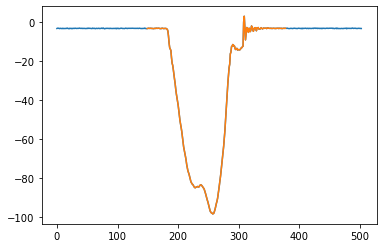

In [3]:
# Plot raw data and statistics
def x(mylist):
    return list(range(0, len(mylist)))

def classCount(dataset):
    count =[0,0]
    for data in dataset:
        myclass = data["class"]
        count[myclass] += 1
    print("Close door ", count[0])
    print("Open door  ", count[1])
classCount(dataset)

def dataLengths(dataset):
    mymax = len(dataset[0]["vals"])
    mymin = mymax
    for data in dataset:
        mylen = len(data["vals"])
        if mylen > mymax:
            mymax = mylen
        if mylen < mymin:
            mymin = mylen
    print("Max", mymax)
    print("Min", mymin)
dataLengths(dataset)

i = 175
data = dataset[i]["vals"]
start = infoset[i]["start"]
stop = infoset[i]["stop"]
myx = x(data)

plt.figure()
plt.plot(myx, data)
plt.plot(myx[start:stop], data[start:stop])

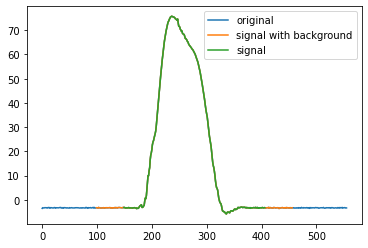

In [4]:
# Step 2 - Cut measuremnts at start/stop + background time
import copy

dataset2 = copy.deepcopy(dataset)
debug = len(dataset) + 1
for i, data in enumerate(dataset2):
    start = infoset[i]["start"]
    start2 = start - BASamples
    stop = infoset[i]["stop"]
    stop2 = stop + BASamples
    vals = data["vals"]
    assert start2 > 0
    assert stop2 < len(vals)
    dataset2[i]["vals"] = vals[start2:stop2]
    if i == debug:
        break

vals1 = dataset[i]["vals"]
vals2 = dataset2[i]["vals"]
myx = x(vals)
plt.plot(myx, vals, label = "original")
plt.plot(myx[start2:stop2], vals[start2:stop2], label = "signal with background")
plt.plot(myx[start:stop], vals[start:stop], label = "signal")
plt.legend()

[89, 2]
[172, 2]


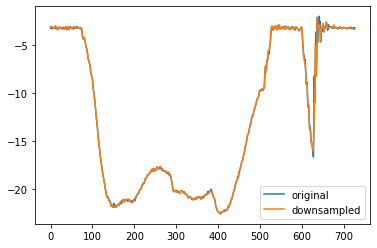

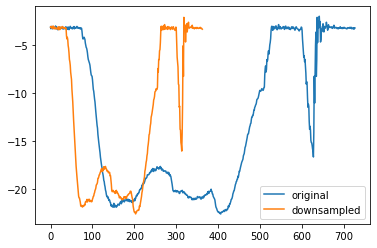

In [5]:
# Step 3 Downsample any too long measurements
dataset = dataset2 # Make step 2 permanent
# Create a list of n lists
def nList(n):
    myList = []
    for i in range(n):
        myList.append([])
    return myList

# Down sample a list of data into factor lists
def downsample(data, factor):
    downData = nList(factor)
    nValsPerSplit = int(len(data) / factor)
    for i in range(nValsPerSplit):
        for j in range(factor):
            index = i * factor + j
            downData[j].append(data[index])
    return downData

# downsample any measurement longer than the max length, starting using a factor of 2, 
# increasing the factor as needed until the len is ok
i = 0
dIs = []
dataset3 = copy.deepcopy(dataset)
for data in dataset3:
    vals = data["vals"]
    if len(vals) > MaxSamples:     
        factor = 2
        while True:
            dVals = downsample(vals,factor)[0]
            if len(dVals) < MaxSamples:
                dataset3[i]["vals"] = dVals
                dIs.append([i, factor])
                print(dIs[-1])
                break
            else:
                factor += 1
            
    i+=1

# Sanity Check Plot
j = 0 # index of downsampeld plot for dIs
plt.figure()
i = dIs[j][0] # index of data that was downsampeld
# Origianl
vals1 = dataset[i]["vals"] 
x1 = x(vals1)
# Downsampled
vals2 = dataset3[i]["vals"]
x2 = x1[::dIs[j][1]][0:len(vals2)]
# Plot using origianl x
plt.plot(x1, vals1, label="original")
plt.plot(x2, vals2, label="downsampled")
plt.legend()
# Plot with downsampeld x
plt.figure()
plt.plot(x1, vals1, label="original")
plt.plot(x(vals2), vals2, label="downsampled")
plt.legend()


In [6]:
# Step 4 - Balance Classes and Split into Train, Val and Test sets

dataset = dataset3 # Make step 2 permanent
# Determines which indicies of the data belongs to which class and then gets random
# indicies for each class 
def getRandomSamples(dataset, split):
    nSplit = int(split * len(dataset) / 2)
    classIs = [[],[]]
    for i, data in enumerate(dataset):
        myclass = data["class"]
        classIs[myclass].append(i)
    class0 = random.sample(classIs[0], nSplit)
    class1 = random.sample(classIs[1], nSplit)
    # Handle uneven classes (more door opens than door closes or vice versa)
    if len(class0) == len(class1): # same 
        class0.extend(class1)
    elif len(class0) < len(class1): # More opens than closses
        class0.extend(class1[0:len(class0)])
    else: # closes > opens
        class1.extend(class0[0:len(class1)])
        class0 = class1
    return class0

def splitTrainTest(dataset, indicies):
    test = []
    train = []
    for i, data in enumerate(dataset):
        if i in indicies:
                test.append(data)
        else:
                train.append(data)
    return train, test

nSamples = len(dataset)
split = .2
testIs = getRandomSamples(dataset, split)
train, test = splitTrainTest(dataset, testIs)
valIs = getRandomSamples(train, split)
train, validation = splitTrainTest(train, valIs)

nTrain = len(train)
nVal = len(validation)
nTest = len(test)
print(nTrain, nVal, nTest)

# Sanity check, make sure that there are no samples shared between train, val and test
for data in dataset:
    count = 0
    if data in train:
        count+=1
    if data in validation:
        count+=1
    if data in test:
        count+=1
    if count > 1:
        raise Exception("Sampling Error")


224 56 70


### Data Augmentation

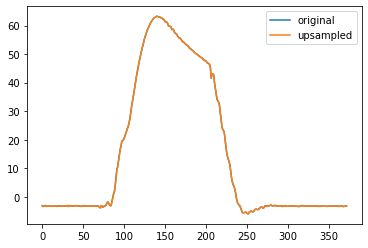

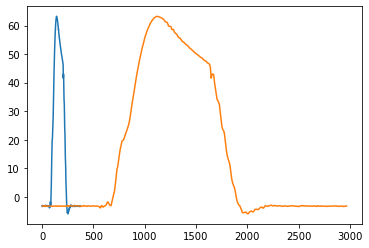

In [7]:
# Step 1 - Upsample signals x times
def interpolate(x1, x2):
    return .5 * x1 + .5 * x2

# Upsamples the values given in a list by a factor of 2 using linear
# interpolation
def upSample(data):
    data2 = []
    for i, val in enumerate(data[:-1]):
        data2.append(val)
        data2.append(interpolate(val, data[i+1]))
    data2.append(data[-1])
    return data2

nUpsample = 3
train2 = copy.deepcopy(train)
for i, data in enumerate(train2): 
    for j in range(nUpsample):
        train2[i]["vals"] = upSample(train2[i]["vals"])


i = 0
# Original values
vals1 = train[i]["vals"]
x1 = x(vals1)
# Upsampled
vals2 = train2[i]["vals"]
x2 = copy.deepcopy(x1)
for j in range(nUpsample):
    x2 = upSample(x2)

plt.figure()
plt.plot(x1, vals1, label = "original")
plt.plot(x2, vals2, label = "upsampled")
plt.legend()

plt.figure()
plt.plot(x1, vals1, label = "original")
plt.plot(x(vals2), vals2, label = "upsampled")

1792


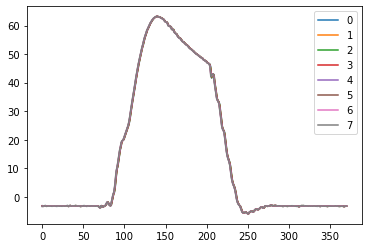

In [8]:
# Step 2 - Downsample upsampeld data
train = train2
train3 = []
nDownScale = 2**nUpsample
for i, data in enumerate(train):
    downDataset = downsample(data["vals"], nDownScale)
    myclass = data["class"]
    for downData in downDataset:
        train3.append({"vals":downData, "class":myclass})
print(len(train3))
i = 0
plt.figure()
for j, data in enumerate(train3[:i+nDownScale]):
    vals = data["vals"]
    plt.plot(x(vals), vals, label=j)
    plt.legend()

# Sanity check to make sure there are duplicates
for i, val in enumerate(train3[:-1]):
    for j, val2 in enumerate(train3[i+1:]):
        if val == val2:
            raise Exception()



23296


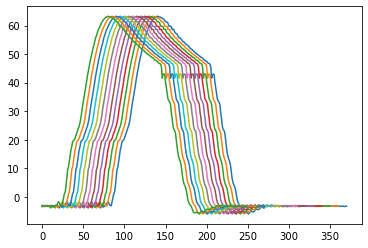

In [9]:
# Step 3 - Cut the extra background time down from 100% to 0% in steps of 10% (10x factor)
train = train3

percent = 10
samples10 = int(SampleRate * BATime / percent) # Number of samples in n percent of BATime
cuts = 13 # 10 would bring us to the start point @ 10 % a cut, 13 means we cut into the signal .3s on begining and end

train4 = []
for i, data in enumerate(train):
    vals = data["vals"]
    myclass = data["class"]
    train4.append({"vals":vals, "class":myclass})
    for i in range(1,cuts):
        sub = i * samples10
        vals = data["vals"][sub:-1*sub]
        myclass = data["class"]
        train4.append({"vals":vals, "class":myclass})
print(len(train4))
i = 0
plt.figure()
for j in range(cuts):
    vals = train4[cuts*i + j]["vals"]
    plt.plot(x(vals), vals, label=i)

# Sanity check to make sure there are duplicates - long
# for i, val in enumerate(train4[:-1]):
#     for j, val2 in enumerate(train4[i+1:]):
#         if val == val2:
#             raise Exception()


### Final Steps

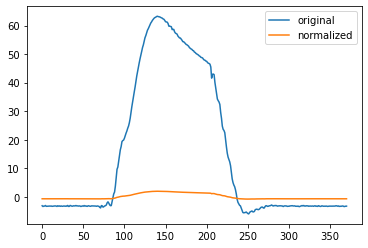

In [10]:
# Step 1 - Normalize data
import numpy as np
train = train4

def normalize(data):
    # mean = np.mean(data,axis=0)
    # sd = np.std(data, axis=0)
    # data2 = (data - mean) / sd
    mean = np.mean(data)
    sd = np.std(data)
    data2 = (data - mean) / sd
    return list(data2)


train2 = []
for i, data in enumerate(train):
    vals = data["vals"]
    myclass = data["class"]
    vals2 = normalize(vals)
    train2.append({"vals":vals2, "class":myclass})

i = 0
vals = train[i]["vals"]
vals2 = train2[i]["vals"]
xs = x(vals)
plt.figure()
plt.plot(xs, vals, label="original")
plt.plot(xs, vals2, label = "normalized")
plt.legend()

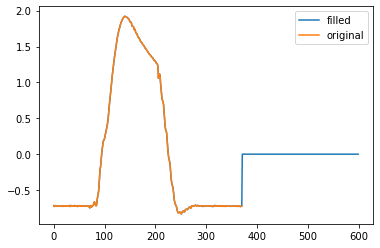

In [11]:
# Step 2 - Fill in with 0s to the max length

train = train2
def fill(data, n, val=0):
    data2 = copy.deepcopy(data)
    diff = n - len(data2)
    for i in range(diff):
        data2.append(0)
    return data2

train3 = []
for i, data in enumerate(train):
    vals = data["vals"]
    myclass = data["class"]
    vals2 = fill(vals, MaxSamples)
    train3.append({"vals":vals2, "class":myclass})

i = 0
vals = train[i]["vals"]
vals2 = train3[i]["vals"]
xs = x(vals)
xs2 = x(vals2)
plt.figure()
plt.plot(xs2, vals2, label = "filled")
plt.plot(xs, vals, label="original")
plt.legend()

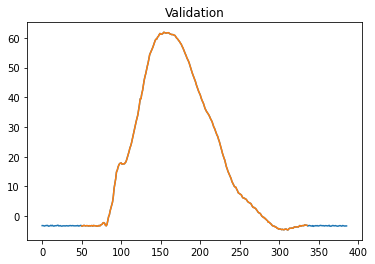

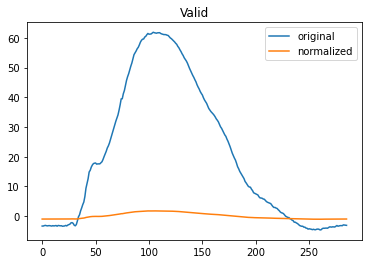

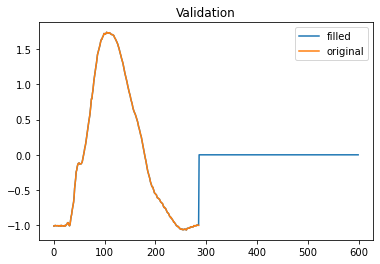

In [12]:
# Step 3 Handle Validation data
# Cut val data down to signal only
## Validation
valid2 = []
BASamples
for i, data in enumerate(validation):
    vals = data["vals"][BASamples:-1*BASamples]
    myclass = data["class"]
    valid2.append({"vals":vals, "class":myclass})

i = 0
vals = validation[i]["vals"]
vals2 = valid2[i]["vals"]
xs = x(vals)
xs2 = xs[BASamples:-1*BASamples]
plt.figure()
plt.title("Validation")
plt.plot(xs, vals)
plt.plot(xs2, vals2)

# normalize
valid3 = []
for i, data in enumerate(valid2):
    vals = data["vals"]
    myclass = data["class"]
    vals2 = normalize(vals)
    valid3.append({"vals":vals2, "class":myclass})

i = 0
vals = valid2[i]["vals"]
vals2 = valid3[i]["vals"]
xs = x(vals)
plt.figure()
plt.title("Valid")
plt.plot(xs, vals, label="original")
plt.plot(xs, vals2, label = "normalized")
plt.legend()

# fill with 0s
valid4 = []
for i, data in enumerate(valid3):
    vals = data["vals"]
    myclass = data["class"]
    vals2 = fill(vals, MaxSamples)
    valid4.append({"vals":vals2, "class":myclass})

i = 0
vals = valid3[i]["vals"]
vals2 = valid4[i]["vals"]
xs = x(vals)
xs2 = x(vals2)
plt.figure()
plt.title("Validation")
plt.plot(xs2, vals2, label = "filled")
plt.plot(xs, vals, label="original")
plt.legend()

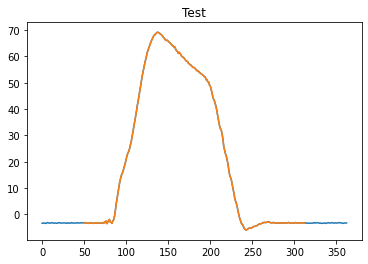

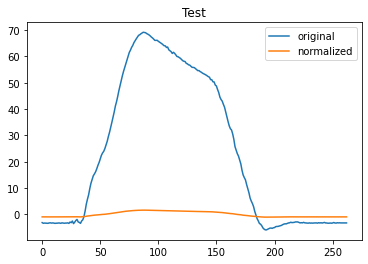

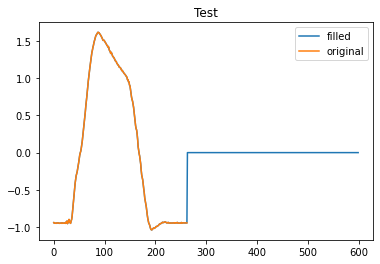

In [13]:
# Step 3 Handle Test data
# Cut test data down to signal only
## TEst
test2 = []
BASamples
for i, data in enumerate(test):
    vals = data["vals"][BASamples:-1*BASamples]
    myclass = data["class"]
    test2.append({"vals":vals, "class":myclass})

i = 0
vals = test[i]["vals"]
vals2 = test2[i]["vals"]
xs = x(vals)
xs2 = xs[BASamples:-1*BASamples]
plt.figure()
plt.title("Test")
plt.plot(xs, vals)
plt.plot(xs2, vals2)

# normalize
test3 = []
for i, data in enumerate(test2):
    vals = data["vals"]
    myclass = data["class"]
    vals2 = normalize(vals)
    test3.append({"vals":vals2, "class":myclass})

i = 0
vals = test2[i]["vals"]
vals2 = test3[i]["vals"]
xs = x(vals)
plt.figure()
plt.title("Test")
plt.plot(xs, vals, label="original")
plt.plot(xs, vals2, label = "normalized")
plt.legend()

# fill with 0s
test4 = []
for i, data in enumerate(test3):
    vals = data["vals"]
    myclass = data["class"]
    vals2 = fill(vals, MaxSamples)
    test4.append({"vals":vals2, "class":myclass})

i = 0
vals = test3[i]["vals"]
vals2 = test4[i]["vals"]
xs = x(vals)
xs2 = x(vals2)
plt.figure()
plt.title("Test")
plt.plot(xs2, vals2, label = "filled")
plt.plot(xs, vals, label="original")
plt.legend()

In [14]:
# Step 4 Write to file
train = train3
validation = valid4
test = test4

def writeData(folder, dataset):
    with open(folder + "gx.csv", "w") as f:
        for i, data in enumerate(dataset):
            vals = data["vals"]
            f.write(str(vals[0]))
            for val in vals[1:]:
                f.write("," + str(val))
            f.write("\n")
    with open(folder + "class.csv", "w") as f:
        for i, data in enumerate(dataset):
            myclass = data["class"]
            f.write(str(myclass) + "\n")


TrainFolder = "data/train/"
ValFolder = "data/val/"
TestFolder = "data/test/"

if not os.path.exists(TrainFolder):
    os.mkdir(TrainFolder)
if not os.path.exists(ValFolder):
    os.mkdir(ValFolder)
if not os.path.exists(TestFolder):
    os.mkdir(TestFolder)

writeData(TrainFolder, train)
writeData(ValFolder, validation)
writeData(TestFolder, test)


In [15]:
# Check that we can read back these files
import pandas as pd

def readBackFiles(folder):
    x = []
    data=pd.read_csv(folder + "gx.csv", header=None)
    check = data.isna().sum()
    if sum(check) > 0:
        raise Exception("NANs in data")
    x.append(data.values)
    x = np.dstack(x)
    y = pd.read_csv(folder + "class.csv", header=None)
    return x, y

x,y = readBackFiles(TrainFolder)
print("Train")
print(x.shape)
print(y.shape)
print("Val")
x,y = readBackFiles(ValFolder)
print(x.shape)
print(y.shape)
print("Test")
x,y = readBackFiles(TestFolder)
print(x.shape)
print(y.shape)

Train
(23296, 600, 1)
(23296, 1)
Val
(56, 600, 1)
(56, 1)
Test
(70, 600, 1)
(70, 1)
